<a href="https://colab.research.google.com/github/nafis-neehal/ML_PROJ_RPI/blob/main/HW3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

#Dataset Description

For this problem, I have used the very famous MNIST dataset, and wanted to explore the performance of a vanilally 2-Layer Neural Network on MNIST. It has handwritten digit samples for all the english digits 0-9. For training, we have 60,000 samples and for test, we have 10,000 samples. I download it from the default pytorch dataset collection. \\
**Objective:** Classify handwritten digits correctly, as many as possible. \\
**Loss:** For this multiclass classification problem, we use an extesion of cross-entropy loss. \\
**State-of-the-art Accuracy:** 99.84% on test set [Paper: https://paperswithcode.com/paper/a-branching-and-merging-convolutional-network]

#Import Libraries

For solving this problem, we use Pytorch Framework. \\
Resources:

*   Pytorch implementation of Neural Networks: https://pytorch.org/docs/stable/nn.html
*   Pytorch loss functions: https://pytorch.org/docs/stable/nn.html#loss-functions
*   Pytorch Optimizer for SGD (ADAM implementation): https://pytorch.org/docs/stable/optim.html 
*   Pytorch calculating gradients with Autograd: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html 
*   Pytorch dataset and dataloader utility for mini-batch training: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html


In [2]:
import torch
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import time

from sklearn.model_selection import train_test_split

torch.manual_seed(101)

# Import Train and Test Data
We download the MNIST data locally and apply transformation (transforming them all to tensor) by default. We can add normalization and standardization and other stuffs here too.

In [3]:
Transform = transforms.ToTensor()
train = datasets.MNIST(root="./DATA", train=True, download=True, transform=Transform)
test = datasets.MNIST(root="./DATA", train=False, download=True, transform=Transform)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#Data Analysis
We will do some exploratory analysis here - 

## Show Sample Data

Shape: torch.Size([1, 28, 28]) 
Label: 5


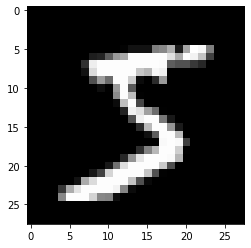

In [4]:
image, label = train[0]
print("Shape:", image.shape, '\nLabel:', label)
plt.imshow(image.reshape((28,28)), cmap='gray')

## Show Class Labels with Value Counts for Imbalance
Here, the dataset is very well refined, so classes are very balanced.

In [34]:
values, counts = torch.unique(train.train_labels, return_counts=True)
[print(x[0].numpy(), x[1].numpy()) for x in list(zip(values, counts))];

0 5923
1 6742
2 5958
3 6131
4 5842
5 5421
6 5918
7 6265
8 5851
9 5949


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


## Split Training Data into 80-20 Training and Validation
So finally, we have - 

*   48,000 training samples
*   12,000 validation samples
*   10,000 test samples



In [5]:
X_train_flatten = torch.reshape(train.data, [60000, 784]).numpy()
y_train = train.train_labels.numpy()

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train_flatten, y_train, test_size=0.20, random_state=42)

In [7]:
train_data = np.concatenate((X_train, y_train.reshape(y_train.shape[0],1)), axis=1)
val_data = np.concatenate((X_val, y_val.reshape(y_val.shape[0],1)), axis=1)

## Data Loaders for Mini-Batch Processing

In [8]:
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
valid_loader = DataLoader(val_data, batch_size=500, shuffle=False)
test_loader = DataLoader(test, batch_size=500, shuffle=False)

#Deep Neural Network Architecture

For this network, I have one hidden layer (dim=128) and one output layer (dim=10, one for each class), both of them are linear in nature. On the hidden layer, I apply ReLU activation, and on the output layer I apply softmax (multi-classification). I also use drouput as a regularization scheme with 20% droupout probability

In [9]:
class DNN(nn.Module):
  def __init__(self, input_size=784, output_size=10):
    super().__init__()
    self.h1 = nn.Linear(input_size, 128)
    self.output = nn.Linear(128, output_size)
    self.dropout = nn.Dropout(0.2)
  
  def forward(self, X):
    X = F.relu(self.h1(X))
    X = self.dropout(X)
    X = self.output(X)
    return F.log_softmax(X, dim=1)

In [10]:
model = DNN()
print(model)

DNN(
  (h1): Linear(in_features=784, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


#Loss function and optimizer

Cross Entropy Loss Function for Multiclass Problem: $$ -\sum_{c=1}^{M}y_{o,c}log(p_{o,c})$$
Where,


*   M - number of classes
*   log - natural log
*   y - binary indicator (0 or 1) if class label c is the correct classification for observation o
*   p - predicted probability observation o is of class c

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Model Training
We train this model for 10 epochs. In each epoch, there are mini-batches of 100 samples. So in total there will be 480 epochs for each batch. The model will train on the whole 48,000 training samples for 10 times. Training and Validation losses and accuracies are saved for each epoch accordingly.



In [12]:
#lists and params
epochs = 10
train_losses = []
val_losses = []
train_acc = []
val_acc = []

for i in range(epochs):
  trn_corr = 0
  val_corr = 0

  #run the training batches
  for b, sample in enumerate(train_loader):
    b+=1

    #split data and labels
    Xtr, ytr = sample[:,:-1], sample[:,-1]

    #apply the model
    y_pred = model(Xtr.view(100,-1).float()) #flatten x_train
    loss = criterion(y_pred, ytr)

    #calculate correct predictions
    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == ytr).sum()
    trn_corr += batch_corr

    #update params
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #print results
    if b%480 == 0:
      print(f'epoch: {i} batch: {b} [{100*b*(i+1):6}/480000] Train loss: {loss.item():0.5f} Train accuracy: {trn_corr.item()*100/48000:0.5f}%')

  train_losses.append(loss)
  train_acc.append(trn_corr.item()*100/48000)

  #run the test batches
  with torch.no_grad(): #don't calculate the gradients during testing
    for b,v_sample in enumerate(valid_loader):

      #split data and labels
      Xv, yv = v_sample[:,:-1], v_sample[:,-1]
      
      #apply the model]
      y_pred_v = model(Xv.view(500, -1).float()) #flatten X_val

      #tally the number of correct predictions
      predicted = torch.max(y_pred_v.data, 1)[1]
      val_corr += (predicted == yv).sum()

  #update test loss and accuracy for the epoch
  loss = criterion(y_pred_v, yv)
  val_losses.append(loss)
  val_acc.append(val_corr.item()*100/12000)

epoch: 0 batch: 480 [ 48000/480000] Train loss: 0.29996 Train accuracy: 85.15000%
epoch: 1 batch: 480 [ 96000/480000] Train loss: 0.22542 Train accuracy: 91.60625%
epoch: 2 batch: 480 [144000/480000] Train loss: 0.15055 Train accuracy: 93.10208%
epoch: 3 batch: 480 [192000/480000] Train loss: 0.14953 Train accuracy: 93.82917%
epoch: 4 batch: 480 [240000/480000] Train loss: 0.13415 Train accuracy: 94.27083%
epoch: 5 batch: 480 [288000/480000] Train loss: 0.17610 Train accuracy: 94.53333%
epoch: 6 batch: 480 [336000/480000] Train loss: 0.19721 Train accuracy: 94.52083%
epoch: 7 batch: 480 [384000/480000] Train loss: 0.22063 Train accuracy: 94.80625%
epoch: 8 batch: 480 [432000/480000] Train loss: 0.22268 Train accuracy: 94.77292%
epoch: 9 batch: 480 [480000/480000] Train loss: 0.09474 Train accuracy: 94.94167%


# Performance on Validation and Test Set

In [14]:
y_pred_test = model(test.data.view(10000, -1).float())
predicted_test = torch.max(y_pred_test.data, 1)[1]
test_accuracy = (predicted_test == test.test_labels).sum().item()*100/10000

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [18]:
print(f'Final Validation accuracy: {val_acc[-1]:0.2f}%')

Validation accuracy: 93.60%


In [19]:
print(f'Final Test Accuracy:{test_accuracy:0.2f}%', )

Test Accuracy:93.93%


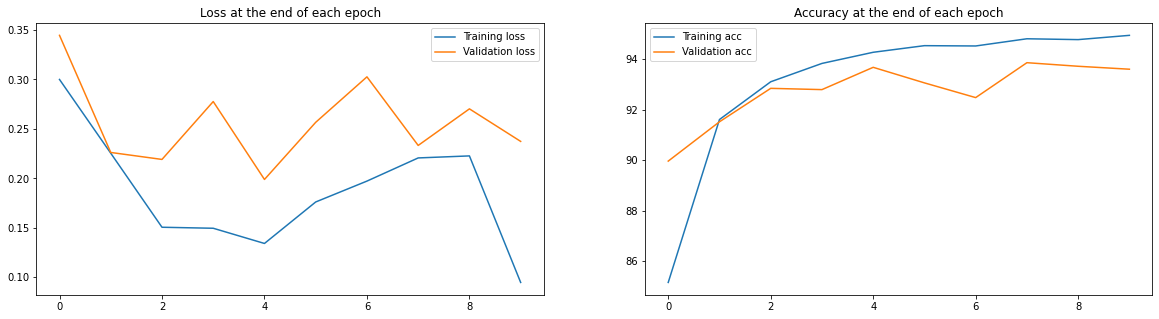

In [16]:
f = plt.figure(figsize=(20,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.plot(train_losses, label="Training loss")
ax.plot(val_losses, label="Validation loss")
ax.set_title("Loss at the end of each epoch")
ax.legend()

ax2.plot(train_acc, label="Training acc")
ax2.plot(val_acc, label="Validation acc")
ax2.set_title('Accuracy at the end of each epoch')
ax2.legend()

# Discussions
**Result:** We get final accuracy about 94% on the Test set, which is not bad at all comparing the vanilla miniman 2-layer architecture we have here. The state of the art architecture used CNN + Homogeneous Filter Capsules for achieving 99.8% accuracy. \\
**Hyperparameter Selection:** The main hyperparameter mainly here was the number of epochs and learning rate. I chose these based on trial-and-error on several values. For number of epochs I tried [5,10,20, 50, 100] and for learning rate I tried [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03]. The best parameters were used from this search. In future I plan to use Hyperparameter tuner like Optuna/Hyperopt for these. \\
**Regularization:** I used dropout regularization on neural network with 20% dropout probability. For small networks with small number of parameters, dropout usually works better than complex regularization schemes like L1/L2/Elastic Net. \\
**GD Optimization:** I used Adam gradient descent optimization algorithm, just based on the popular choice in literature.